CREDIT RATING DATA MART - FULL ETL PIPELINE

In [4]:
import os
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

Paths

In [5]:
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
RAW_FILE = os.path.join(ROOT, "data", "credit_rating_dataset.csv")
PROCESSED_DIR = os.path.join(ROOT, "data", "processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)

print(" Using raw file:", RAW_FILE)

 Using raw file: c:\3-1\Projects\data\credit_rating_dataset.csv


EXTRACT - Load dataset

In [6]:
df = pd.read_csv(RAW_FILE)
print(" Loaded dataset:", df.shape)
display(df.head(5))

 Loaded dataset: (2368, 11)


,security_id,security_name,sector,country,vendor,rating_type,rating_date,rating_code,vendor_code,vendor_id,source_feed_id
0,SEC_1000,Security_0,Telecom,Germany,DBRS,Long Term,2021-01-01,A+,DBR762,2,FEED_8869
1,SEC_1000,Security_0,Telecom,Germany,DBRS,Long Term,2021-06-10,AAA,DBR320,2,FEED_3956
2,SEC_1000,Security_0,Telecom,Germany,DBRS,Long Term,2021-03-10,B+,DBR952,2,FEED_8710
3,SEC_1000,Security_0,Telecom,Germany,DBRS,Long Term,2022-12-10,B,DBR595,2,FEED_7017
4,SEC_1000,Security_0,Telecom,Germany,DBRS,Long Term,2021-10-12,BB-,DBR336,2,FEED_4384


TRANSFORM - Clean & normalize data

In [7]:
df.columns = [c.strip().lower() for c in df.columns]


expected_cols = ["security_id", "security_name", "sector", "country", "vendor",
                 "rating_type", "rating_date", "rating_code"]
missing_cols = [c for c in expected_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f" Missing required columns: {missing_cols}")

df["rating_date"] = pd.to_datetime(df["rating_date"], errors="coerce")
df = df.dropna(subset=["rating_date"])

df = df.drop_duplicates().reset_index(drop=True)


df["sector"] = df["sector"].fillna("Unknown")
df["country"] = df["country"].fillna("Unknown")
df["rating_code"] = df["rating_code"].fillna("UNRATED")

Standardize Ratings

In [9]:
rating_map = {
    "AAA": "AAA", "AA+": "AA", "AA": "AA", "AA-": "AA",
    "A+": "A", "A": "A", "A-": "A",
    "BBB+": "BBB", "BBB": "BBB", "BBB-": "BBB",
    "BB+": "BB", "BB": "BB", "BB-": "BB",
    "B+": "B", "B": "B", "CCC": "CCC", "CC": "CC", "C": "C",
    "D": "D", "NR": "UNRATED"
}
df["standard_rating"] = df["rating_code"].map(rating_map).fillna("UNRATED")

Add Rating Score

In [10]:
scale_order = {"AAA":0, "AA":1, "A":2, "BBB":3, "BB":4, "B":5, "CCC":6, "CC":7, "C":8, "D":9, "UNRATED":10}
df["rating_score"] = df["standard_rating"].map(scale_order).fillna(10).astype(int)

Build SCD Type-2 Table

In [11]:
scd_rows = []
for (sec, ven, rtype), grp in df.groupby(["security_id", "vendor", "rating_type"], sort=True):
    grp = grp.sort_values("rating_date").reset_index(drop=True)
    active_record = None
    for _, row in grp.iterrows():
        start = row["rating_date"]
        rating = row["standard_rating"]
        if active_record is None:
            active_record = {
                "security_id": sec,
                "vendor": ven,
                "rating_type": rtype,
                "standard_rating": rating,
                "effective_start_date": start,
                "effective_end_date": pd.NaT,
                "is_active": 1
            }
        elif rating != active_record["standard_rating"]:
            active_record["effective_end_date"] = start - timedelta(days=1)
            active_record["is_active"] = 0
            scd_rows.append(active_record)
            active_record = {
                "security_id": sec,
                "vendor": ven,
                "rating_type": rtype,
                "standard_rating": rating,
                "effective_start_date": start,
                "effective_end_date": pd.NaT,
                "is_active": 1
            }
    if active_record:
        scd_rows.append(active_record)

ratings_type2 = pd.DataFrame(scd_rows)
print(" SCD Type-2 rows:", len(ratings_type2))
display(ratings_type2.head(10))

 SCD Type-2 rows: 2122


,security_id,vendor,rating_type,standard_rating,effective_start_date,effective_end_date,is_active
0,SEC_1000,DBRS,Long Term,A,2021-01-01,2021-03-09,0
1,SEC_1000,DBRS,Long Term,B,2021-03-10,2021-06-09,0
2,SEC_1000,DBRS,Long Term,AAA,2021-06-10,2021-10-11,0
3,SEC_1000,DBRS,Long Term,BB,2021-10-12,2022-12-09,0
4,SEC_1000,DBRS,Long Term,B,2022-12-10,NaT,1
5,SEC_1000,Fitch,Short Term,BBB,2021-01-01,2021-06-11,0
6,SEC_1000,Fitch,Short Term,BB,2021-06-12,2021-07-05,0
7,SEC_1000,Fitch,Short Term,AA,2021-07-06,2021-07-28,0
8,SEC_1000,Fitch,Short Term,CC,2021-07-29,2022-03-02,0
9,SEC_1000,Fitch,Short Term,A,2022-03-03,2022-07-22,0


Compute KPI: Rating Change Frequency

In [12]:
df = df.sort_values(["security_id","vendor","rating_type","rating_date"])
df["prev_rating"] = df.groupby(["security_id","vendor","rating_type"])["standard_rating"].shift(1)
df["is_change"] = (df["standard_rating"] != df["prev_rating"]).astype(int)
df.loc[df["prev_rating"].isna(), "is_change"] = 1

df["year"] = df["rating_date"].dt.year
rating_freq = df.groupby(["vendor","year"])["is_change"].sum().reset_index().rename(columns={"is_change":"rating_change_count"})
print(" KPI rating change frequency sample:")
display(rating_freq.head(10))

 KPI rating change frequency sample:


,vendor,year,rating_change_count
0,CARE,2021,111
1,CARE,2022,58
2,CARE,2023,27
3,CARE,2024,17
4,CARE,2025,13
5,DBRS,2021,117
6,DBRS,2022,61
7,DBRS,2023,54
8,DBRS,2024,32
9,DBRS,2025,17


Outlier Detection (Vendor disagreement)

In [13]:
pivot = df.pivot_table(index=["security_id", "rating_date", "rating_type"], columns="vendor", values="rating_score", aggfunc="first").reset_index()
vendor_cols = [c for c in pivot.columns if c not in ["security_id", "rating_date", "rating_type"]]

pivot["score_min"] = pivot[vendor_cols].min(axis=1, skipna=True)
pivot["score_max"] = pivot[vendor_cols].max(axis=1, skipna=True)
pivot["score_diff"] = (pivot["score_max"] - pivot["score_min"]).fillna(0)
pivot["is_outlier"] = (pivot["score_diff"] >= 2).astype(int)

outlier_pct_by_date = pivot.groupby("rating_date")["is_outlier"].mean().reset_index().rename(columns={"is_outlier":"outlier_pct"})
print(" Outlier percentage by date:")
display(outlier_pct_by_date.head(10))

pivot["precision"] = pivot[vendor_cols].notna().sum(axis=1) / len(vendor_cols)
pivot["total_vendors"] = pivot[vendor_cols].notna().sum(axis=1)

 Outlier percentage by date:


,rating_date,outlier_pct
0,2021-01-01,0.311111
1,2021-01-31,0.000000
2,2021-02-01,0.000000
3,2021-02-03,0.000000
4,2021-02-04,0.000000
5,2021-02-06,0.000000
6,2021-02-07,0.000000
7,2021-02-08,0.000000
8,2021-02-10,0.000000
9,2021-02-11,0.000000


SAVE processed files

In [14]:
df.to_csv(os.path.join(PROCESSED_DIR, "transactions_cleaned.csv"), index=False)
ratings_type2.to_csv(os.path.join(PROCESSED_DIR, "ratings_type2_sample.csv"), index=False)
rating_freq.to_csv(os.path.join(PROCESSED_DIR, "rating_frequency_per_vendor_year.csv"), index=False)
pivot.to_csv(os.path.join(PROCESSED_DIR, "outlier_precision_by_security_date.csv"), index=False)

print(" Processed files saved to:", PROCESSED_DIR)
print(os.listdir(PROCESSED_DIR))


 Processed files saved to: c:\3-1\Projects\data\processed
['outlier_precision_by_security_date.csv', 'ratings_type2_sample.csv', 'rating_frequency_per_vendor_year.csv', 'transactions_cleaned.csv']


Visual Validation (optional)

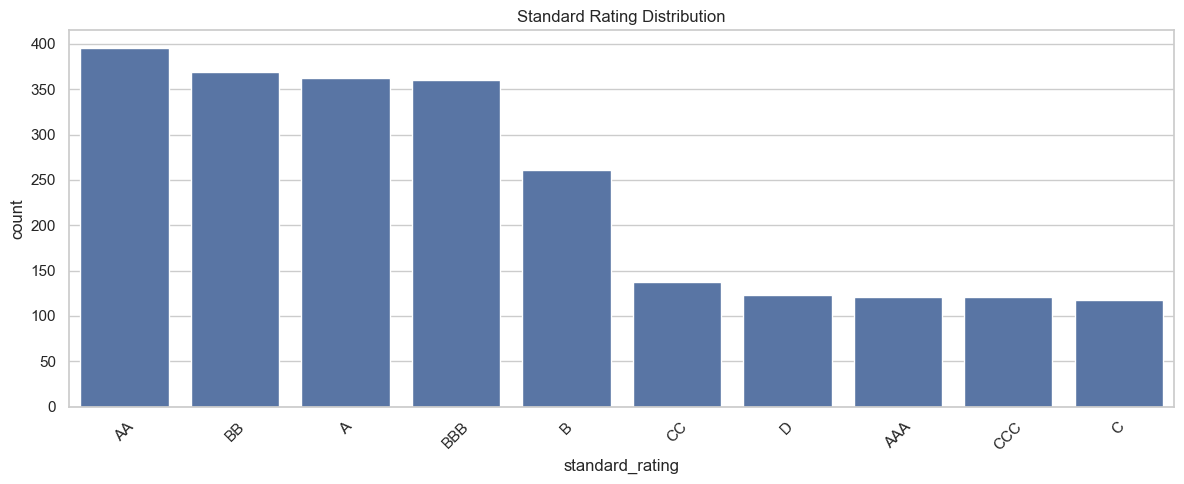

In [15]:
sns.set(style="whitegrid")

plt.figure(figsize=(12,5))
sns.countplot(data=df, x="standard_rating", order=df["standard_rating"].value_counts().index)
plt.title("Standard Rating Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

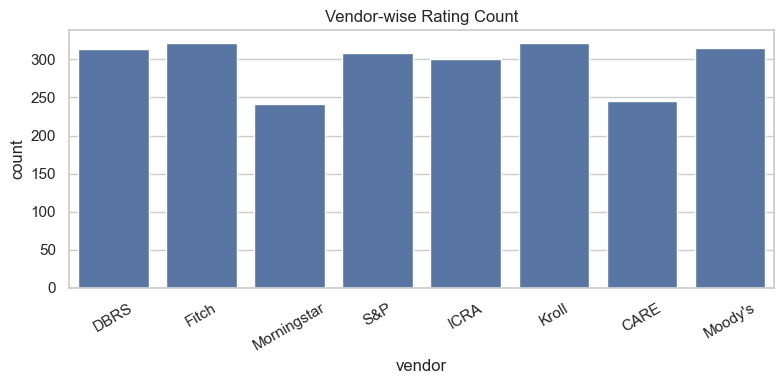

In [14]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="vendor")
plt.title("Vendor-wise Rating Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

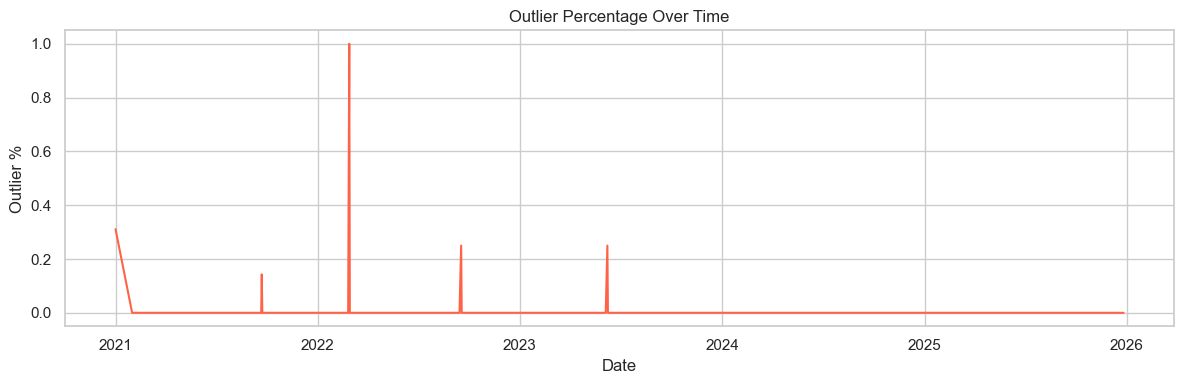

 ETL pipeline execution complete!


In [16]:
plt.figure(figsize=(12,4))
plt.plot(outlier_pct_by_date["rating_date"], outlier_pct_by_date["outlier_pct"], color="tomato")
plt.title("Outlier Percentage Over Time")
plt.ylabel("Outlier %")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

print(" ETL pipeline execution complete!")